# Install and Import Dependencies

### Install softwares w/ conda and pip

In [ ]:
#!/usr/bin/env python3

In [1]:
#pip install opencv-python matplotlib imageio gdown tensorflow

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.5.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.5.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [3]:
#!pip list

Package                       Version
----------------------------- ---------------
absl-py                       1.4.0
aiohttp                       3.8.3
aiosignal                     1.2.0
alabaster                     0.7.12
anaconda-client               1.11.2
anaconda-navigator            2.4.0
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout                 4.0.2
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.11.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.w

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
from numba import njit

2023-07-10 14:12:40.812340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Prevent exponential memory growth

In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass


# Build Data Loading Function

### Download and Extract Files

In [4]:
import gdown

In [5]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=29fea417-b6d1-499d-8af2-8cfd940853c4
To: /home/m245034/projects/LipNet/data.zip
100%|████████████████████████████████████████| 423M/423M [00:13<00:00, 30.3MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

### Data Loading Function

In [6]:
# turn video into usable data
def load_video(path:str) -> List[float]:
    
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        #isolates mouth use Dlib to isolate mouth to update
        frames.append(frame[190:236, 80:220,:])        
    cap.release()
    
    #help focus on vital data
    mean = tf.math.reduce_mean(frames)
    std =tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames-mean), tf.float32) / std

In [7]:
# all available charcters
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [8]:
#convert text to num and vice versa
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [9]:
#use alignments

def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        #ignore silence value
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [10]:
#load alignements and videos simultaneously

def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    #file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments


### Test Code

In [60]:
test_path = './data/s1/bbal6n.mpg'

In [61]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [62]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))
max_frame=len(frames)



In [63]:
#largest frame for imshow
print(str(max_frame-1))

74


In [64]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [15]:
# characters from data
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])
#condensed words from data
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])


['b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'l', ' ', 's', 'i', 'x', ' ', 'n', 'o', 'w']


<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

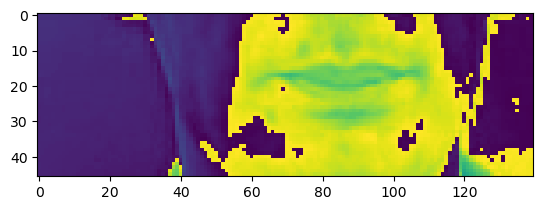

In [16]:
# image
plt.imshow(frames[20])

In [17]:
def mappable_function(path:str) ->List[str]:
    #tensorflow for pure string processing needs py_function
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result


# Create Data Pipeline

In [38]:
#make dataset
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
#shuffle data
data = data.shuffle(500, reshuffle_each_iteration=False)
#transfer data through pipeline and get it back
data = data.map(mappable_function)
#ensure 75 frames and 40 tokens
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
#optimizng preloading data
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [39]:
frames, alignments = data.as_numpy_iterator().next()

### Test

In [40]:
#test to see that the data is padded
alignments

array([[12,  1, 25, 39,  7, 18,  5,  5, 14, 39,  1, 20, 39, 12, 39, 14,
         9, 14,  5, 39, 19, 15, 15, 14,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  9, 14, 39, 23,  8,  9, 20,  5, 39, 23,  9, 20,  8, 39,  1,
        39, 14,  9, 14,  5, 39, 19, 15, 15, 14,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [41]:
#test
sample = data.as_numpy_iterator()

In [42]:
val =sample.next(); val[0]

array([[[[[ 1.3833274 ],
          [ 1.3833274 ],
          [ 1.3426414 ],
          ...,
          [ 0.0406861 ],
          [ 0.1220583 ],
          [ 0.0813722 ]],

         [[ 1.3833274 ],
          [ 1.3833274 ],
          [ 1.3426414 ],
          ...,
          [ 0.0813722 ],
          [ 0.2034305 ],
          [ 0.2034305 ]],

         [[ 1.3019552 ],
          [ 1.3019552 ],
          [ 1.3019552 ],
          ...,
          [ 0.        ],
          [ 0.0406861 ],
          [ 0.0406861 ]],

         ...,

         [[ 0.9357803 ],
          [ 0.9357803 ],
          [ 0.9357803 ],
          ...,
          [10.130839  ],
          [10.130839  ],
          [10.130839  ]],

         [[ 0.9357803 ],
          [ 0.9357803 ],
          [ 0.9357803 ],
          ...,
          [10.130839  ],
          [10.130839  ],
          [10.130839  ]],

         [[ 0.9357803 ],
          [ 0.9357803 ],
          [ 0.9357803 ],
          ...,
          [10.130839  ],
          [10.130839  ],
          

In [43]:
#changes dataset into a gif 
#can change 2nd number value to either 0 or 1
fv=(val[0][1].astype(np.uint8) * 255).squeeze()
imageio.mimsave('./animation.gif',fv, duration=50)

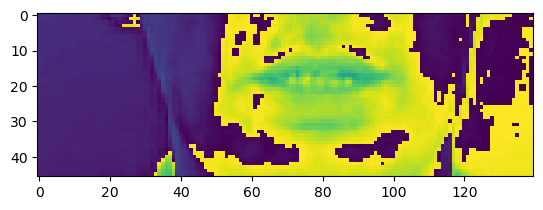

In [44]:
#plots out the image
# videos, 1st vid out of batch, return first frame in the video
plt.imshow(val[0][0][30])

In [80]:
samp=val[1][1]
sam=val[1][0]

In [84]:
num_to_char(samp)


<tf.Tensor: shape=(40,), dtype=string, numpy=
array([b's', b'e', b't', b' ', b'w', b'h', b'i', b't', b'e', b' ', b'w',
       b'i', b't', b'h', b' ', b'j', b' ', b'z', b'e', b'r', b'o', b' ',
       b'p', b'l', b'e', b'a', b's', b'e', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b''], dtype=object)>

In [85]:
print([bytes.decode(x) for x in num_to_char(samp).numpy()])

['s', 'e', 't', ' ', 'w', 'h', 'i', 't', 'e', ' ', 'w', 'i', 't', 'h', ' ', 'j', ' ', 'z', 'e', 'r', 'o', ' ', 'p', 'l', 'e', 'a', 's', 'e', '', '', '', '', '', '', '', '', '', '', '', '']


In [86]:
#decodes gif
tf.strings.reduce_join([num_to_char(word) for word in val[1][1]])
#print[tf.strings.reduce_join([num_to_char(word) for word in val[]

#condensed words from data
#tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])
# characters from data
#print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'set white with j zero please'>

# Design Deep Neural Network


In [87]:
#import more dependencies
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [88]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [89]:
model = Sequential()
# 3 sets of convulusions
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

#flatten convulsions w/ timedistrubted layer
model.add(TimeDistributed(Flatten()))

#Two sets of LSTMs
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

#Dense Layer
model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [90]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [91]:
#testing [predictions data]
yhat = model.predict(val[0])

1/1 [==============================] - 4s 4s/step


In [92]:
#the predicted output in charactesr
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])
numpy()]


<tf.Tensor: shape=(), dtype=string, numpy=b'lllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllllb6'>

In [94]:
sam=tf.argmax(yhat[0],axis=1)


In [95]:
print([bytes.decode(x) for x in num_to_char(sam).numpy()])

['l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'l', 'b', '6']


In [36]:
#tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

In [37]:
#model.input_shape

In [38]:
#model.output_shape

# Training Setup and Train


In [39]:
# define learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [40]:
#define CTC loss
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [41]:
class ProduceExample(tf.keras.callbacks.Callback):
    
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [42]:
#Compiles our model
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

### Define Callbacks

In [43]:
#Save model checkpoints
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [44]:
#Scheulder should drop the learning rate
schedule_callback = LearningRateScheduler(scheduler)

In [45]:
#make predictions after each epoch
example_callback = ProduceExample(test)

In [46]:
#model.fit(train, validation_data=test, epochs=1, callbacks=[checkpoint_callback, schedule_callback, example_callback])

# Make Prediction

In [47]:
#url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
#output = 'checkpoints.zip'
#gdown.download(url, output, quiet=False)
#gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=11c17ed4-13ee-48a1-9f98-c21682e0c161
To: /home/m245034/projects/LipNet/checkpoints.zip
100%|██████████████████████████████████████| 94.5M/94.5M [00:04<00:00, 22.9MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [49]:
#model.load_weights('models/checkpoint')

ValueError: You are trying to restore a checkpoint from a legacy Keras optimizer into a v2.11+ Optimizer, which can cause errors. Please update the optimizer referenced in your code to be an instance of `tf.keras.optimizers.legacy.Optimizer`, e.g.: `tf.keras.optimizers.legacy.Adam`.